In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('max_colwidth', 5000)
import pandas_profiling
from IPython.display import display
from feature_engine.categorical_encoders import OneHotCategoricalEncoder

## Load Data From CSV File

First thing is merging the csv file into one file <br />
Here is the code:
`cat *.csv >merged.csv`
<br/>
**Note:** to read the csv file in, need to do `skiprows=1` and `low_memory=False`

<br/>
Next, take a look at the data. Simple command to explore the data so I can explore over time

In [2]:
from sklearn.model_selection import train_test_split as tts

In [3]:
df_backup = pd.read_csv('/Users/fayadabbasi/Desktop/Python_Scripts/Galvanize/DSI/CreditRisk/merged.csv', skiprows=1, low_memory=False)

In [4]:
df = df_backup.copy()

### First Modification
Since I have the merged `.csv` files, I need to drop the redundant rows
<br/>
There should be 16 of them

In [5]:
df = df[df.id!='id'] # leave behind those that do not have id in the id column
# due to csv merge, need to eliminate rows with redundant index; 16 of these

### Next, Check Loan Status
Want to see loan_status counts

In [6]:
df.loan_status.value_counts()

Fully Paid                                             1191125
Current                                                 868848
Charged Off                                             287174
Late (31-120 days)                                       20775
In Grace Period                                           9242
Late (16-30 days)                                         4826
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     42
Name: loan_status, dtype: int64

Create a dataframe with the most likely fields to analyze for loan performance
<br/>
Note that I can look at a variety of items in the future but this is initial analysis.

In [7]:
df = df[['loan_amnt','grade','emp_length','annual_inc','purpose','revol_util','home_ownership','term','int_rate','loan_status']]

In [8]:
df.head(2)

,loan_amnt,grade,emp_length,annual_inc,purpose,revol_util,home_ownership,term,int_rate,loan_status
0,5000,B,10+ years,24000,credit_card,83.7%,RENT,36 months,10.65%,Fully Paid
1,2500,C,< 1 year,30000,car,9.4%,RENT,60 months,15.27%,Charged Off


### Preprocessing

First convert object items to numeric - only two fields
<br/>
Then apply my universal preprocessing function to do broader cleaning

In [9]:
convert_to_numeric = ['loan_amnt','annual_inc']
for items in convert_to_numeric:
    df[items] = pd.to_numeric(df[items])

In [10]:
def pre_processing(dataframe, date='2019-8-01'):
    def emp_length(dataframe,column='emp_length'):
        dataframe[column+'_int'] = dataframe[column]
        dataframe[column+'_int'] = dataframe[column+'_int'].str.replace('\+ years','')
        dataframe[column+'_int'] = dataframe[column+'_int'].str.replace('< 1 year',str(0))
        dataframe[column+'_int'] = dataframe[column+'_int'].str.replace('n\a',str(0))
        dataframe[column+'_int'] = dataframe[column+'_int'].str.replace(' years','')
        dataframe[column+'_int'] = dataframe[column+'_int'].str.replace(' year','')
        dataframe[column+'_int'] = pd.to_numeric(dataframe[column+'_int'])
        dataframe[column+'_int'].fillna(0, inplace=True)
    
    def term_length(dataframe, column='term'):
        dataframe[column+'_int'] = dataframe[column]
        dataframe[column+'_int'] = dataframe[column].str.replace(' months','')
        dataframe[column+'_int'] = pd.to_numeric(dataframe[column+'_int'])
    
    def perc_convert(dataframe, column):
        dataframe[column+'_t'] = dataframe[column].fillna(str('0'))
        dataframe[column+'_factor'] = dataframe[column+'_t'].map(lambda x: str(x).rstrip('%').strip())
        dataframe[column+'_factor'] = pd.to_numeric(dataframe[column+'_factor'])
    
    emp_length(dataframe)
    term_length(dataframe)
    perc_convert(dataframe, column='int_rate')
    perc_convert(dataframe, column='revol_util')

    dataframe['annual_inc'].fillna(dataframe['annual_inc'].mean(), inplace=True)
    dataframe['good_bad'] = np.where(dataframe['loan_status'].isin(['Charged Off','Default','Does not meet the credit policy. Status:Fully Paid','Does not meet the credit policy. Status:Charged Off','Late (31-120 days)','Late (16-30 days)']),0,1)
    
    return dataframe

In [11]:
df = pre_processing(df)

In [12]:
df.head(2)

,loan_amnt,grade,emp_length,annual_inc,purpose,revol_util,home_ownership,term,int_rate,loan_status,emp_length_int,term_int,int_rate_t,int_rate_factor,revol_util_t,revol_util_factor,good_bad
0,5000.0,B,10+ years,24000.0,credit_card,83.7%,RENT,36 months,10.65%,Fully Paid,10.0,36.0,10.65%,10.65,83.7%,83.7,1
1,2500.0,C,< 1 year,30000.0,car,9.4%,RENT,60 months,15.27%,Charged Off,0.0,60.0,15.27%,15.27,9.4%,9.4,0


In [13]:
df = df.drop(['emp_length','term','int_rate','int_rate_t','revol_util','revol_util_t'], axis=1)

In [14]:
def missing_values(dataframe,column):
    dataframe = dataframe[dataframe[column].notnull()]
    return dataframe

In [15]:
df = missing_values(df,'loan_amnt') 

In [16]:
def null_values(d):
    mis_valu = d.isnull().sum()
    mis_val_percent = 100* d.isnull().sum() / len(d)
    mis_val_table = pd.concat([mis_valu, mis_val_percent],axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns={0: 'Missing Values', 1: '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1]!=0].sort_values('% of Total Values', ascending=False).round(1)
    print("Dataframe has " + str(d.shape[1]) + " columns.\nThere are "+ str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
    return mis_val_table_ren_columns

In [17]:
miss_values = null_values(df)

Dataframe has 11 columns.
There are 0 columns that have missing values.


In [18]:
df.head(2)

,loan_amnt,grade,annual_inc,purpose,home_ownership,loan_status,emp_length_int,term_int,int_rate_factor,revol_util_factor,good_bad
0,5000.0,B,24000.0,credit_card,RENT,Fully Paid,10.0,36.0,10.65,83.7,1
1,2500.0,C,30000.0,car,RENT,Charged Off,0.0,60.0,15.27,9.4,0


### View a few plots

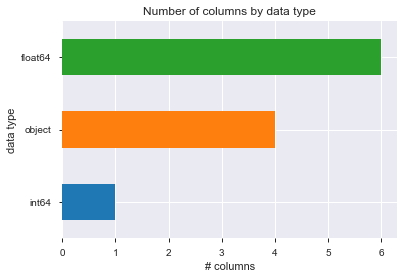

In [19]:
df.dtypes.value_counts().sort_values().plot(kind='barh')
plt.title('Number of columns by data type')
plt.xlabel("number of columns")
plt.ylabel("data type");

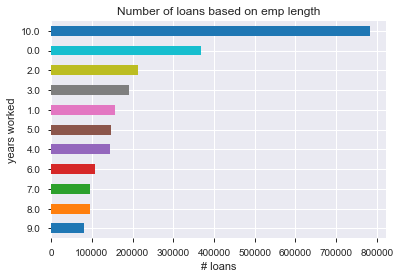

In [20]:
df['emp_length_int'].value_counts().sort_values().plot(kind='barh')
plt.title('Number of loans based on emp length')
plt.xlabel('number of loans')
plt.ylabel('years worked');

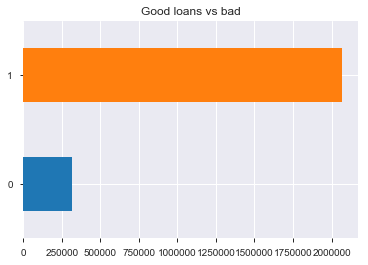

In [21]:
df.good_bad.value_counts().sort_values().plot(kind='barh')
plt.title('Good loans vs bad');

### Create One Hot Encoding for Categorical Items
There are 5 columns that are already in categorical form

In [22]:
lst = ['grade','home_ownership','purpose','emp_length_int','term_int']
def loan_data_d(dataframe, lst = []):
    for items in lst:
        loan_data_dummies = [pd.get_dummies(dataframe[items], prefix=items,prefix_sep=':')]
        loan_data_dummies = pd.concat(loan_data_dummies, axis=1)
        dataframe = pd.concat([dataframe, loan_data_dummies], axis = 1)
    return dataframe

In [23]:
df = loan_data_d(df,lst)

In [24]:
df = df.drop(lst, axis=1)

In [25]:
df.head(2)

,loan_amnt,annual_inc,loan_status,int_rate_factor,revol_util_factor,good_bad,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,emp_length_int:0.0,emp_length_int:1.0,emp_length_int:2.0,emp_length_int:3.0,emp_length_int:4.0,emp_length_int:5.0,emp_length_int:6.0,emp_length_int:7.0,emp_length_int:8.0,emp_length_int:9.0,emp_length_int:10.0,term_int:36.0,term_int:60.0
0,5000.0,24000.0,Fully Paid,10.65,83.7,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,2500.0,30000.0,Charged Off,15.27,9.4,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [26]:
df['loan_status'].value_counts() / df['loan_status'].count()

Fully Paid                                             0.499469
Current                                                0.364330
Charged Off                                            0.120419
Late (31-120 days)                                     0.008711
In Grace Period                                        0.003875
Late (16-30 days)                                      0.002024
Does not meet the credit policy. Status:Fully Paid     0.000834
Does not meet the credit policy. Status:Charged Off    0.000319
Default                                                0.000018
Name: loan_status, dtype: float64

### Create Train Test Split

In [172]:
loan_data_input_train, loan_data_input_test, loan_data_target_train, loan_data_target_test = tts(df.drop(['loan_status','good_bad'], axis=1), df['good_bad'], test_size=0.25, random_state=42)

In [173]:
df_inputs_prepr, df_targets_prepr = loan_data_input_train, loan_data_target_train

### Create One Hot Encoding for Continuous Variables
Will do a Weight of Evidence to see how to break down continuous variables to bins based on WoE

In [ ]:
def woe_ordered_continuous(df, discrete_variable_name, good_bad_variable_df):
    df = pd.concat([df[discrete_variable_name], good_bad_variable_df],axis=1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].count(),df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].mean()], axis=1)
    df = df.iloc[:,[0,1,3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1-df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good']/ df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    # df = df.sort_values(['WoE'])
    # df = df.reset_index(drop=True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [175]:
df_inputs_prepr['loan_amnt_factor'] = pd.cut(df_inputs_prepr['loan_amnt'],30)
#df_inputs_prepr['loan_amnt_factor'] = pd.cut(df_inputs_prepr['loan_amnt'],5).astype(str)
# df_inputs_prepr.loan_amnt_factor[0].replace('(','').replace(']','').replace(' ','').split(',')[1]

In [178]:
df_temp = woe_ordered_continuous(df_inputs_prepr,'loan_amnt_factor',df_targets_prepr)
df_temp

,loan_amnt_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(460.5, 1816.667]",22280,0.909246,0.012457,20258.0,2022.0,0.013052,0.008552,0.422808,NaN,NaN,0.031895
1,"(1816.667, 3133.333]",61094,0.893590,0.034158,54593.0,6501.0,0.035173,0.027494,0.246295,0.015656,0.176513,0.031895
2,"(3133.333, 4450.0]",61247,0.887717,0.034243,54370.0,6877.0,0.035029,0.029084,0.185975,0.005873,0.060320,0.031895
3,"(4450.0, 5766.667]",111706,0.885736,0.062455,98942.0,12764.0,0.063746,0.053982,0.166250,0.001981,0.019725,0.031895
4,"(5766.667, 7083.333]",119687,0.887030,0.066917,106166.0,13521.0,0.068400,0.057184,0.179105,0.001295,0.012855,0.031895
5,"(7083.333, 8400.0]",107454,0.873453,0.060078,93856.0,13598.0,0.060469,0.057509,0.050184,0.013578,0.128921,0.031895
6,"(8400.0, 9716.667]",60820,0.871868,0.034005,53027.0,7793.0,0.034164,0.032958,0.035921,0.001585,0.014264,0.031895
7,"(9716.667, 11033.333]",200095,0.878378,0.111873,175759.0,24336.0,0.113237,0.102923,0.095502,0.006510,0.059582,0.031895
8,"(11033.333, 12350.0]",123226,0.856597,0.068896,105555.0,17671.0,0.068006,0.074735,-0.094348,0.021781,0.189850,0.031895
9,"(12350.0, 13666.667]",46806,0.857454,0.026169,40134.0,6672.0,0.025857,0.028218,-0.087351,0.000857,0.006997,0.031895


In [179]:
def plot_by_woe(df_WoE, rotation_of_x_axis_label=0):
    x = np.array(df_WoE.iloc[:,0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18,6))
    plt.plot(x,y,marker='o', linestyle='--',color='k')
    plt.xlabel = (df_WoE.columns[0])
    plt.ylabel = ('Weight of Evidence')
    plt.title(str('Weight of Evidence by '+ df_WoE.columns[0]))
    plt.xticks(rotation=rotation_of_x_axis_label)

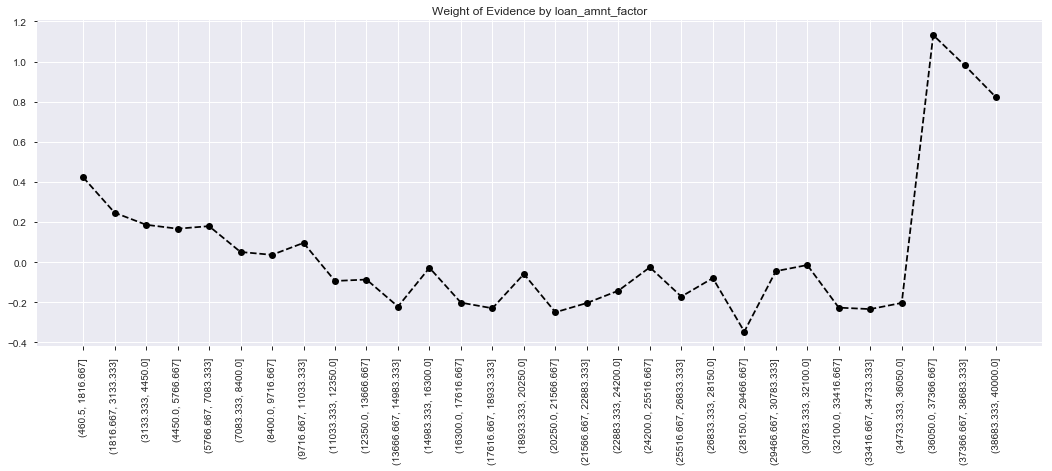

In [180]:
plot_by_woe(df_temp, 90)

In [181]:
df_inputs_prepr['loan_amnt_factor:1'] = np.where((df_inputs_prepr['loan_amnt_factor'].isin(range(1817))),1,0)
df_inputs_prepr['loan_amnt_factor:2'] = np.where((df_inputs_prepr['loan_amnt_factor'].isin(range(1817,7084))),1,0)
df_inputs_prepr['loan_amnt_factor:3'] = np.where((df_inputs_prepr['loan_amnt_factor'].isin(range(7084,11034))),1,0)
df_inputs_prepr['loan_amnt_factor:4'] = np.where((df_inputs_prepr['loan_amnt_factor'].isin(range(11034,28150))),1,0)
df_inputs_prepr['loan_amnt_factor:5'] = np.where((df_inputs_prepr['loan_amnt_factor'].isin(range(28150,28160))),1,0)
df_inputs_prepr['loan_amnt_factor:6'] = np.where((df_inputs_prepr['loan_amnt_factor'].isin(range(28160,32100))),1,0)
df_inputs_prepr['loan_amnt_factor:7'] = np.where((df_inputs_prepr['loan_amnt_factor'].isin(range(32100,36050))),1,0)
df_inputs_prepr['loan_amnt_factor:8'] = np.where((df_inputs_prepr['loan_amnt_factor'].isin(range(36050,int(df_inputs_prepr['loan_amnt'].max())))),1,0)

In [182]:
df_inputs_prepr.head(2)

,loan_amnt,annual_inc,int_rate_factor,revol_util_factor,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,emp_length_int:0.0,emp_length_int:1.0,emp_length_int:2.0,emp_length_int:3.0,emp_length_int:4.0,emp_length_int:5.0,emp_length_int:6.0,emp_length_int:7.0,emp_length_int:8.0,emp_length_int:9.0,emp_length_int:10.0,term_int:36.0,term_int:60.0,loan_amnt_factor,loan_amnt_factor:1,loan_amnt_factor:2,loan_amnt_factor:3,loan_amnt_factor:4,loan_amnt_factor:5,loan_amnt_factor:6,loan_amnt_factor:7,loan_amnt_factor:8
1378684,32000.0,94000.0,15.99,75.8,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,"(30783.333, 32100.0]",0,0,0,0,0,1,1,0
1047648,14400.0,60000.0,11.99,12.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,"(13666.667, 14983.333]",0,0,0,1,0,0,0,0


In [183]:
df_inputs_prepr = df_inputs_prepr.drop(['loan_amnt', 'loan_amnt_factor'], axis=1)

In [184]:
df_inputs_prepr['annual_inc_factor'] = pd.cut(df_inputs_prepr['annual_inc'],100)

In [185]:
df_inputs_prepr_temp = df_inputs_prepr.loc[df_inputs_prepr['annual_inc']<140000,:]

In [186]:
df_inputs_prepr_temp['annual_inc_factor'] = pd.cut(df_inputs_prepr_temp['annual_inc'],20)

/Users/fayadabbasi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [187]:
df_temp = woe_ordered_continuous(df_inputs_prepr_temp,'annual_inc_factor',df_targets_prepr[df_inputs_prepr_temp.index])
df_temp

,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-139.999, 6999.95]",2642,0.921650,0.001619,2435.0,207.0,0.001727,0.000933,0.615973,NaN,NaN,0.023823
1,"(6999.95, 13999.9]",7808,0.846952,0.004785,6613.0,1195.0,0.004691,0.005385,-0.138119,0.074698,0.754092,0.023823
2,"(13999.9, 20999.85]",25426,0.838708,0.015582,21325.0,4101.0,0.015126,0.018481,-0.200361,0.008243,0.062242,0.023823
3,"(20999.85, 27999.8]",53860,0.837579,0.033007,45112.0,8748.0,0.031997,0.039423,-0.208687,0.001130,0.008326,0.023823
4,"(27999.8, 34999.75]",93435,0.839086,0.057260,78400.0,15035.0,0.055608,0.067755,-0.197567,0.001507,0.011120,0.023823
5,"(34999.75, 41999.7]",154114,0.845186,0.094446,130255.0,23859.0,0.092389,0.107520,-0.151678,0.006100,0.045889,0.023823
6,"(41999.7, 48999.65]",150516,0.848308,0.092241,127684.0,22832.0,0.090565,0.102892,-0.127615,0.003122,0.024063,0.023823
7,"(48999.65, 55999.6]",187025,0.855688,0.114615,160035.0,26990.0,0.113511,0.121630,-0.069084,0.007379,0.058531,0.023823
8,"(55999.6, 62999.55]",153143,0.858910,0.093851,131536.0,21607.0,0.093297,0.097372,-0.042747,0.003222,0.026337,0.023823
9,"(62999.55, 69999.5]",120460,0.863980,0.073822,104075.0,16385.0,0.073819,0.073839,-0.000265,0.005070,0.042482,0.023823


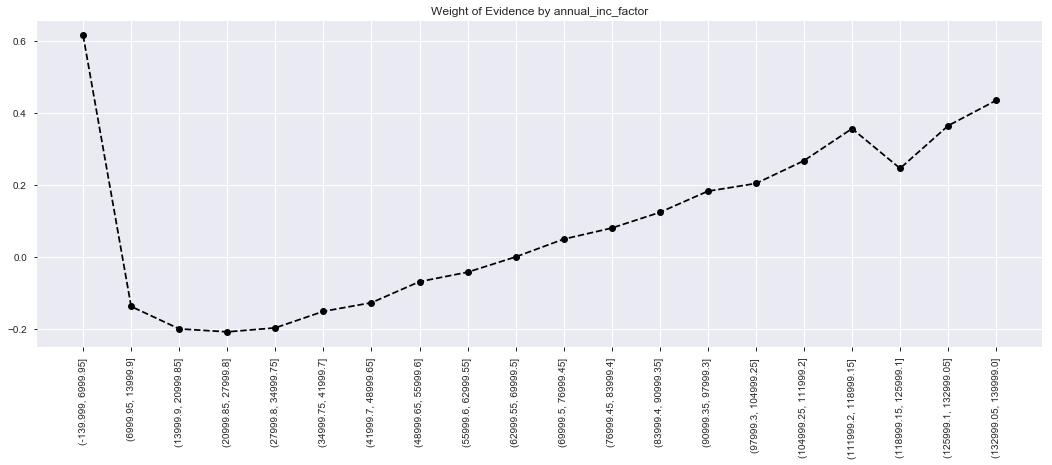

In [188]:
plot_by_woe(df_temp, 90)

In [189]:
df_inputs_prepr['annual_inc_factor:1'] = np.where((df_inputs_prepr['annual_inc_factor'].isin(range(7000))),1,0)
df_inputs_prepr['annual_inc_factor:2'] = np.where((df_inputs_prepr['annual_inc_factor'].isin(range(7000,42000))),1,0)
df_inputs_prepr['annual_inc_factor:3'] = np.where((df_inputs_prepr['annual_inc_factor'].isin(range(42000,70000))),1,0)
df_inputs_prepr['annual_inc_factor:4'] = np.where((df_inputs_prepr['annual_inc_factor'].isin(range(70000,100000))),1,0)
df_inputs_prepr['annual_inc_factor:5'] = np.where((df_inputs_prepr['annual_inc_factor'].isin(range(100000,112000))),1,0)
df_inputs_prepr['annual_inc_factor:6'] = np.where((df_inputs_prepr['annual_inc_factor'].isin(range(112000,126000))),1,0)
df_inputs_prepr['annual_inc_factor:7'] = np.where((df_inputs_prepr['annual_inc_factor'].isin(range(126000,int(df_inputs_prepr['annual_inc'].max())))),1,0)

In [190]:
df_inputs_prepr = df_inputs_prepr.drop(['annual_inc','annual_inc_factor'], axis=1)

In [191]:
df_inputs_prepr['int_rate_factor_f'] = pd.cut(df_inputs_prepr['int_rate_factor'],10)

In [192]:
df_temp = woe_ordered_continuous(df_inputs_prepr,'int_rate_factor_f',df_targets_prepr)
df_temp

,int_rate_factor_f,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(5.284, 7.878]",249264,0.968567,0.139364,241429.0,7835.0,0.155546,0.033136,1.546320,NaN,NaN,0.437131
1,"(7.878, 10.446]",320097,0.930218,0.178967,297760.0,22337.0,0.191839,0.094469,0.708389,0.038349,0.837931,0.437131
2,"(10.446, 13.014]",411013,0.886330,0.229798,364293.0,46720.0,0.234704,0.197590,0.172131,0.043888,0.536257,0.437131
3,"(13.014, 15.582]",326701,0.849716,0.182659,277603.0,49098.0,0.178852,0.207647,-0.149281,0.036614,0.321412,0.437131
4,"(15.582, 18.15]",228846,0.804401,0.127948,184084.0,44762.0,0.118600,0.189309,-0.467622,0.045315,0.318341,0.437131
5,"(18.15, 20.718]",127408,0.762378,0.071234,97133.0,30275.0,0.062580,0.128040,-0.715896,0.042024,0.248274,0.437131
6,"(20.718, 23.286]",59965,0.735596,0.033527,44110.0,15855.0,0.028419,0.067055,-0.858453,0.026782,0.142557,0.437131
7,"(23.286, 25.854]",39994,0.703431,0.022361,28133.0,11861.0,0.018125,0.050163,-1.017967,0.032165,0.159514,0.437131
8,"(25.854, 28.422]",13541,0.689240,0.007571,9333.0,4208.0,0.006013,0.017797,-1.085086,0.014190,0.067119,0.437131
9,"(28.422, 30.99]",11756,0.702450,0.006573,8258.0,3498.0,0.005320,0.014794,-1.022664,0.013210,0.062422,0.437131


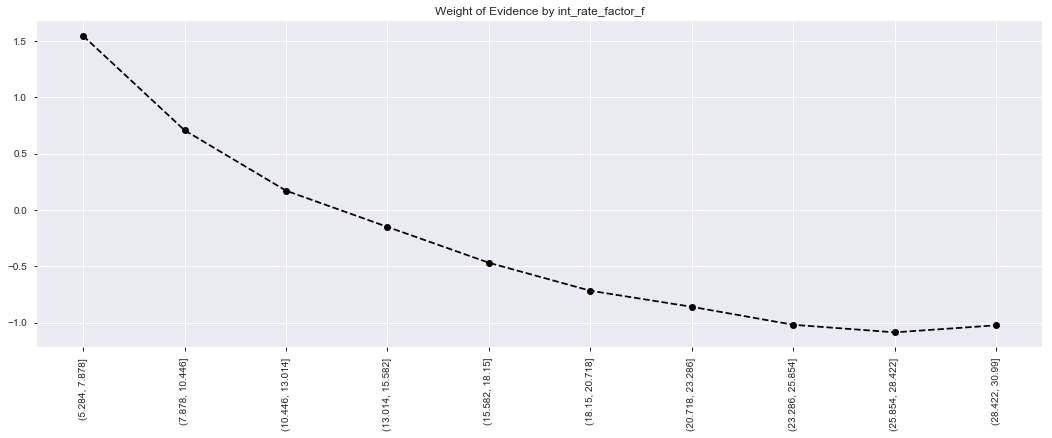

In [193]:
plot_by_woe(df_temp, 90)

In [194]:
df_inputs_prepr['int_rate_factor:1'] = np.where((df_inputs_prepr['int_rate_factor_f'].isin(range(8))),1,0)
df_inputs_prepr['int_rate_factor:2'] = np.where((df_inputs_prepr['int_rate_factor_f'].isin(range(8,11))),1,0)
df_inputs_prepr['int_rate_factor:3'] = np.where((df_inputs_prepr['int_rate_factor_f'].isin(range(11,13))),1,0)
df_inputs_prepr['int_rate_factor:4'] = np.where((df_inputs_prepr['int_rate_factor_f'].isin(range(13,15))),1,0)
df_inputs_prepr['int_rate_factor:5'] = np.where((df_inputs_prepr['int_rate_factor_f'].isin(range(15,17))),1,0)
df_inputs_prepr['int_rate_factor:6'] = np.where((df_inputs_prepr['int_rate_factor_f'].isin(range(17,19))),1,0)
df_inputs_prepr['int_rate_factor:7'] = np.where((df_inputs_prepr['int_rate_factor_f'].isin(range(19,21))),1,0)
df_inputs_prepr['int_rate_factor:8'] = np.where((df_inputs_prepr['int_rate_factor_f'].isin(range(21,23))),1,0)
df_inputs_prepr['int_rate_factor:9'] = np.where((df_inputs_prepr['int_rate_factor_f'].isin(range(23,25))),1,0)
df_inputs_prepr['int_rate_factor:10'] = np.where((df_inputs_prepr['int_rate_factor_f'].isin(range(25,27))),1,0)
df_inputs_prepr['int_rate_factor:11'] = np.where((df_inputs_prepr['int_rate_factor_f'].isin(range(27,int(df_inputs_prepr['int_rate_factor'].max())))),1,0)

In [195]:
df_inputs_prepr = df_inputs_prepr.drop(['int_rate_factor','int_rate_factor_f'], axis=1)

In [196]:
df_inputs_prepr['revol_util_factor_f'] = pd.cut(df_inputs_prepr['revol_util_factor'],30)

In [197]:
df_temp = woe_ordered_continuous(df_inputs_prepr,'revol_util_factor_f',df_targets_prepr)
df_temp

/Users/fayadabbasi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/Users/fayadabbasi/anaconda3/lib/python3.7/site-packages/pandas/core/algorithms.py:1823: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,revol_util_factor_f,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.367, 12.22]",127270,0.905807,7.115681e-02,115282.0,11988.0,0.074273,0.050700,0.381820,NaN,NaN,inf
1,"(12.22, 24.44]",190313,0.902151,1.064042e-01,171691.0,18622.0,0.110616,0.078757,0.339698,0.003656,0.042122,inf
2,"(24.44, 36.66]",262426,0.884958,1.467227e-01,232236.0,30190.0,0.149623,0.127681,0.158589,0.017193,0.181109,inf
3,"(36.66, 48.88]",295553,0.870182,1.652440e-01,257185.0,38368.0,0.165697,0.162268,0.020917,0.014776,0.137671,inf
4,"(48.88, 61.1]",297253,0.857882,1.661945e-01,255008.0,42245.0,0.164295,0.178664,-0.083846,0.012300,0.104763,inf
5,"(61.1, 73.32]",258864,0.849697,1.447312e-01,219956.0,38908.0,0.141712,0.164551,-0.149427,0.008185,0.065581,inf
6,"(73.32, 85.54]",201884,0.845099,1.128736e-01,170612.0,31272.0,0.109921,0.132257,-0.184986,0.004598,0.035559,inf
7,"(85.54, 97.76]",134476,0.841340,7.518569e-02,113140.0,21336.0,0.072893,0.090235,-0.213425,0.003759,0.028439,inf
8,"(97.76, 109.98]",20171,0.829359,1.127763e-02,16729.0,3442.0,0.010778,0.014557,-0.300564,0.011981,0.087139,inf
9,"(109.98, 122.2]",255,0.803922,1.425708e-04,205.0,50.0,0.000132,0.000211,-0.470668,0.025437,0.170104,inf


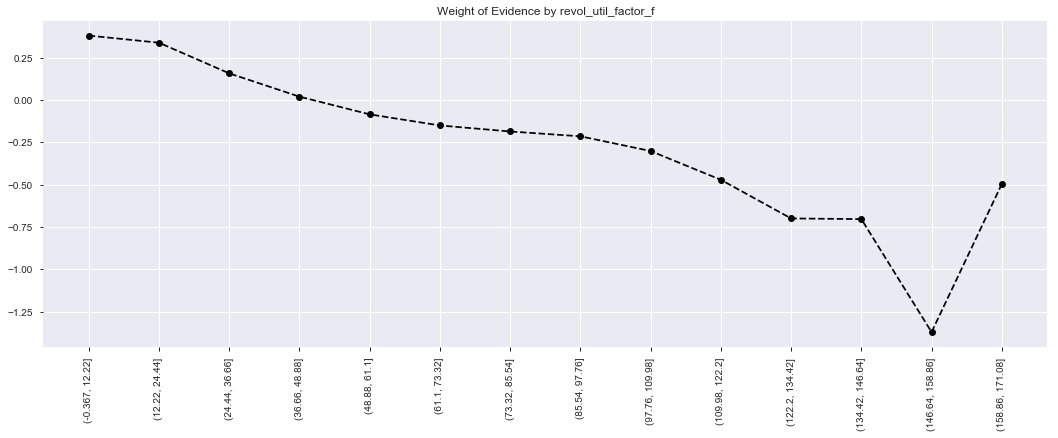

In [198]:
plot_by_woe(df_temp, 90)

In [199]:
df_inputs_prepr['revol_util_factor:1'] = np.where((df_inputs_prepr['revol_util_factor_f'].isin(range(12))),1,0)
df_inputs_prepr['revol_util_factor:2'] = np.where((df_inputs_prepr['revol_util_factor_f'].isin(range(12,24))),1,0)
df_inputs_prepr['revol_util_factor:3'] = np.where((df_inputs_prepr['revol_util_factor_f'].isin(range(24,36))),1,0)
df_inputs_prepr['revol_util_factor:4'] = np.where((df_inputs_prepr['revol_util_factor_f'].isin(range(36,48))),1,0)
df_inputs_prepr['revol_util_factor:5'] = np.where((df_inputs_prepr['revol_util_factor_f'].isin(range(48,60))),1,0)
df_inputs_prepr['revol_util_factor:6'] = np.where((df_inputs_prepr['revol_util_factor_f'].isin(range(60,72))),1,0)
df_inputs_prepr['revol_util_factor:7'] = np.where((df_inputs_prepr['revol_util_factor_f'].isin(range(72,84))),1,0)
df_inputs_prepr['revol_util_factor:8'] = np.where((df_inputs_prepr['revol_util_factor_f'].isin(range(84,96))),1,0)
df_inputs_prepr['revol_util_factor:9'] = np.where((df_inputs_prepr['revol_util_factor_f'].isin(range(96,int(df_inputs_prepr['revol_util_factor'].max())))),1,0)

In [200]:
df_inputs_prepr = df_inputs_prepr.drop(['revol_util_factor','revol_util_factor_f'], axis=1)

In [201]:
df_inputs_prepr.head(2)
# will need to make sure I am dropping columns as I do the appends

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,emp_length_int:0.0,emp_length_int:1.0,emp_length_int:2.0,emp_length_int:3.0,emp_length_int:4.0,emp_length_int:5.0,emp_length_int:6.0,emp_length_int:7.0,emp_length_int:8.0,emp_length_int:9.0,emp_length_int:10.0,term_int:36.0,term_int:60.0,loan_amnt_factor:1,loan_amnt_factor:2,loan_amnt_factor:3,loan_amnt_factor:4,loan_amnt_factor:5,loan_amnt_factor:6,loan_amnt_factor:7,loan_amnt_factor:8,annual_inc_factor:1,annual_inc_factor:2,annual_inc_factor:3,annual_inc_factor:4,annual_inc_factor:5,annual_inc_factor:6,annual_inc_factor:7,int_rate_factor:1,int_rate_factor:2,int_rate_factor:3,int_rate_factor:4,int_rate_factor:5,int_rate_factor:6,int_rate_factor:7,int_rate_factor:8,int_rate_factor:9,int_rate_factor:10,int_rate_factor:11,revol_util_factor:1,revol_util_factor:2,revol_util_factor:3,revol_util_factor:4,revol_util_factor:5,revol_util_factor:6,revol_util_factor:7,revol_util_factor:8,revol_util_factor:9
1378684,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,1,1,1,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1047648,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,1,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0


In [202]:
loan_data_target_train.head(1)

1378684    1
Name: good_bad, dtype: int64

In [203]:
df_inputs_prepr.shape

(1788585, 75)

### Apply same breakdown for test data
Since I did train test split already, need to make sure applying the same methodology to test data

In [204]:
df_inputs_prepr_t, df_targets_prepr_t = loan_data_input_test, loan_data_target_test

In [205]:
df_inputs_prepr_t['loan_amnt_factor'] = pd.cut(df_inputs_prepr_t['loan_amnt'],30)

In [206]:
df_inputs_prepr_t['loan_amnt_factor:1'] = np.where((df_inputs_prepr_t['loan_amnt_factor'].isin(range(1817))),1,0)
df_inputs_prepr_t['loan_amnt_factor:2'] = np.where((df_inputs_prepr_t['loan_amnt_factor'].isin(range(1817,7084))),1,0)
df_inputs_prepr_t['loan_amnt_factor:3'] = np.where((df_inputs_prepr_t['loan_amnt_factor'].isin(range(7084,11034))),1,0)
df_inputs_prepr_t['loan_amnt_factor:4'] = np.where((df_inputs_prepr_t['loan_amnt_factor'].isin(range(11034,28150))),1,0)
df_inputs_prepr_t['loan_amnt_factor:5'] = np.where((df_inputs_prepr_t['loan_amnt_factor'].isin(range(28150,28160))),1,0)
df_inputs_prepr_t['loan_amnt_factor:6'] = np.where((df_inputs_prepr_t['loan_amnt_factor'].isin(range(28160,32100))),1,0)
df_inputs_prepr_t['loan_amnt_factor:7'] = np.where((df_inputs_prepr_t['loan_amnt_factor'].isin(range(32100,36050))),1,0)
df_inputs_prepr_t['loan_amnt_factor:8'] = np.where((df_inputs_prepr_t['loan_amnt_factor'].isin(range(36050,int(df_inputs_prepr_t['loan_amnt'].max())))),1,0)

In [207]:
df_inputs_prepr_t = df_inputs_prepr_t.drop(['loan_amnt', 'loan_amnt_factor'], axis=1)

In [208]:
df_inputs_prepr_t['annual_inc_factor'] = pd.cut(df_inputs_prepr_t['annual_inc'],100)

In [209]:
df_inputs_prepr_t['annual_inc_factor:1'] = np.where((df_inputs_prepr_t['annual_inc_factor'].isin(range(7000))),1,0)
df_inputs_prepr_t['annual_inc_factor:2'] = np.where((df_inputs_prepr_t['annual_inc_factor'].isin(range(7000,42000))),1,0)
df_inputs_prepr_t['annual_inc_factor:3'] = np.where((df_inputs_prepr_t['annual_inc_factor'].isin(range(42000,70000))),1,0)
df_inputs_prepr_t['annual_inc_factor:4'] = np.where((df_inputs_prepr_t['annual_inc_factor'].isin(range(70000,100000))),1,0)
df_inputs_prepr_t['annual_inc_factor:5'] = np.where((df_inputs_prepr_t['annual_inc_factor'].isin(range(100000,112000))),1,0)
df_inputs_prepr_t['annual_inc_factor:6'] = np.where((df_inputs_prepr_t['annual_inc_factor'].isin(range(112000,126000))),1,0)
df_inputs_prepr_t['annual_inc_factor:7'] = np.where((df_inputs_prepr_t['annual_inc_factor'].isin(range(126000,int(df_inputs_prepr_t['annual_inc'].max())))),1,0)

In [210]:
df_inputs_prepr_t = df_inputs_prepr_t.drop(['annual_inc','annual_inc_factor'], axis=1)

In [211]:
df_inputs_prepr_t['int_rate_factor_f'] = pd.cut(df_inputs_prepr_t['int_rate_factor'],10)

In [212]:
df_inputs_prepr_t['int_rate_factor:1'] = np.where((df_inputs_prepr_t['int_rate_factor_f'].isin(range(8))),1,0)
df_inputs_prepr_t['int_rate_factor:2'] = np.where((df_inputs_prepr_t['int_rate_factor_f'].isin(range(8,11))),1,0)
df_inputs_prepr_t['int_rate_factor:3'] = np.where((df_inputs_prepr_t['int_rate_factor_f'].isin(range(11,13))),1,0)
df_inputs_prepr_t['int_rate_factor:4'] = np.where((df_inputs_prepr_t['int_rate_factor_f'].isin(range(13,15))),1,0)
df_inputs_prepr_t['int_rate_factor:5'] = np.where((df_inputs_prepr_t['int_rate_factor_f'].isin(range(15,17))),1,0)
df_inputs_prepr_t['int_rate_factor:6'] = np.where((df_inputs_prepr_t['int_rate_factor_f'].isin(range(17,19))),1,0)
df_inputs_prepr_t['int_rate_factor:7'] = np.where((df_inputs_prepr_t['int_rate_factor_f'].isin(range(19,21))),1,0)
df_inputs_prepr_t['int_rate_factor:8'] = np.where((df_inputs_prepr_t['int_rate_factor_f'].isin(range(21,23))),1,0)
df_inputs_prepr_t['int_rate_factor:9'] = np.where((df_inputs_prepr_t['int_rate_factor_f'].isin(range(23,25))),1,0)
df_inputs_prepr_t['int_rate_factor:10'] = np.where((df_inputs_prepr_t['int_rate_factor_f'].isin(range(25,27))),1,0)
df_inputs_prepr_t['int_rate_factor:11'] = np.where((df_inputs_prepr_t['int_rate_factor_f'].isin(range(27,int(df_inputs_prepr_t['int_rate_factor'].max())))),1,0)

In [213]:
df_inputs_prepr_t = df_inputs_prepr_t.drop(['int_rate_factor','int_rate_factor_f'], axis=1)

In [214]:
df_inputs_prepr_t['revol_util_factor_f'] = pd.cut(df_inputs_prepr_t['revol_util_factor'],30)

In [215]:
df_inputs_prepr_t['revol_util_factor:1'] = np.where((df_inputs_prepr_t['revol_util_factor_f'].isin(range(12))),1,0)
df_inputs_prepr_t['revol_util_factor:2'] = np.where((df_inputs_prepr_t['revol_util_factor_f'].isin(range(12,24))),1,0)
df_inputs_prepr_t['revol_util_factor:3'] = np.where((df_inputs_prepr_t['revol_util_factor_f'].isin(range(24,36))),1,0)
df_inputs_prepr_t['revol_util_factor:4'] = np.where((df_inputs_prepr_t['revol_util_factor_f'].isin(range(36,48))),1,0)
df_inputs_prepr_t['revol_util_factor:5'] = np.where((df_inputs_prepr_t['revol_util_factor_f'].isin(range(48,60))),1,0)
df_inputs_prepr_t['revol_util_factor:6'] = np.where((df_inputs_prepr_t['revol_util_factor_f'].isin(range(60,72))),1,0)
df_inputs_prepr_t['revol_util_factor:7'] = np.where((df_inputs_prepr_t['revol_util_factor_f'].isin(range(72,84))),1,0)
df_inputs_prepr_t['revol_util_factor:8'] = np.where((df_inputs_prepr_t['revol_util_factor_f'].isin(range(84,96))),1,0)
df_inputs_prepr_t['revol_util_factor:9'] = np.where((df_inputs_prepr_t['revol_util_factor_f'].isin(range(96,int(df_inputs_prepr_t['revol_util_factor'].max())))),1,0)

In [216]:
df_inputs_prepr_t = df_inputs_prepr_t.drop(['revol_util_factor','revol_util_factor_f'], axis=1)

In [217]:
loan_data_input_train = df_inputs_prepr
loan_data_input_test = df_inputs_prepr_t

## Logistic Regression Modeling

In [218]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [219]:
from sklearn import linear_model
import scipy.stats as stat

In [224]:
loan_data_target_train = pd.DataFrame(loan_data_target_train)

In [229]:
loan_data_target_test = pd.DataFrame(loan_data_target_test)

In [226]:
print("input train shape: {} \ntargets train shape: {}".format(loan_data_input_train.shape, loan_data_target_train.shape))

input train shape: (1788585, 75) 
targets train shape: (1788585, 1)


In [230]:
print("inputs test shape: {} \ntargets test shape: {}".format(loan_data_input_test.shape, loan_data_target_test.shape))

inputs test shape: (596196, 75) 
targets test shape: (596196, 1)


### Drop k-1 from One Hot Encoding

In [231]:
ref_categories = ['grade:G','home_ownership:RENT','purpose:wedding','emp_length_int:10.0','revol_util_factor:9','int_rate_factor:11','annual_inc_factor:7','loan_amnt_factor:8','term_int:60.0']

In [232]:
input_train = loan_data_input_train

In [233]:
input_train = input_train.drop(ref_categories, axis=1)

In [234]:
reg = LogisticRegression()

In [235]:
reg.fit(input_train, loan_data_target_train)

/Users/fayadabbasi/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [236]:
feature_name = input_train.columns.values
summary_table = pd.DataFrame(columns=['Feature name'], data=feature_name)
summary_table['Coefficients'] = np.transpose(reg.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table

,Feature name,Coefficients
0,Intercept,1.108513
1,grade:A,3.749299
2,grade:B,3.155008
3,grade:C,2.538188
4,grade:D,1.820178
5,grade:E,0.968513
6,grade:F,0.305412
7,home_ownership:ANY,1.328037
8,home_ownership:MORTGAGE,0.269970
9,home_ownership:NONE,-0.170585


In [237]:
print("Linear Regression training model score: {:.3%}".format(reg.score(input_train,loan_data_target_train)))

Linear Regression training model score: 86.779%


### Apply model to test data set

In [238]:
input_test = loan_data_input_test

In [241]:
input_test = input_test.drop(ref_categories, axis=1)

In [242]:
yhat_test = reg.predict(input_test)

In [243]:
yhat_test_proba = reg.predict_proba(input_test)

In [244]:
yhat_test_proba = yhat_test_proba[: ][: ,1]

In [245]:
loan_data_targets_test_temp = loan_data_target_test

In [246]:
loan_data_targets_test_temp.shape

(596196, 1)

In [247]:
loan_data_targets_test_temp.reset_index(drop = True, inplace = True)

In [248]:
df_actual_predicted_probs = pd.concat([loan_data_targets_test_temp, pd.DataFrame(yhat_test_proba)], axis=1)

In [249]:
df_actual_predicted_probs.columns = ['loan_data_targets_test','yhat_test_proba']

In [251]:
df_actual_predicted_probs.index = loan_data_input_test.index

In [252]:
df_actual_predicted_probs.head()

,loan_data_targets_test,yhat_test_proba
1946925,1,0.915966
2112432,1,0.937687
1734738,1,0.824680
896150,0,0.826767
734854,1,0.900025


### Apply ROC Curve
Also take a look at confusion matrix

In [307]:
tr = 0.7
df_actual_predicted_probs['yhat_test'] = np.where(df_actual_predicted_probs['yhat_test_proba'] > tr, 1, 0)

In [308]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['yhat_test'], rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,9804,69313
1,15824,501255


In [309]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['yhat_test'], rownames=['Actual'], colnames=['Predicted']) / df_actual_predicted_probs.shape[0]

Predicted,0,1
Actual,,
0,0.016444,0.116259
1,0.026542,0.840755


In [310]:
from sklearn.metrics import roc_curve, roc_auc_score

In [311]:
roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['yhat_test_proba'])

(array([0.        , 0.        , 0.        , ..., 0.99994944, 0.99994944,
        1.        ]),
 array([1.93394046e-06, 3.28769878e-05, 3.86788092e-05, ...,
        9.99998066e-01, 1.00000000e+00, 1.00000000e+00]),
 array([0.99383587, 0.99220689, 0.99210715, ..., 0.27325846, 0.26544191,
        0.07459798]))

In [312]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['yhat_test_proba'])

TypeError: 'str' object is not callable

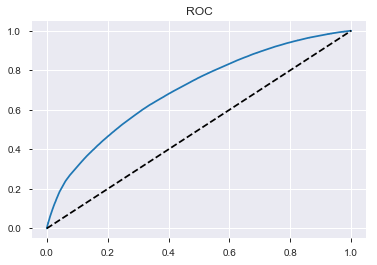

In [313]:
plt.plot(fpr,tpr)
plt.plot(fpr,fpr, linestyle='--', color='k')
plt.title('ROC')
plt.xlabel('False Pos Rate')
plt.ylabel('True Pos Rate');

In [314]:
auroc = roc_auc_score(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['yhat_test_proba'])

In [315]:
print("The Area Under the Curve for the ROC is: {:3f}".format(auroc))

The Area Under the Curve for the ROC is: 0.699893


In [316]:
from sklearn.ensemble import GradientBoostingClassifier

In [317]:
y_glb = loan_data_target_train.iloc[:,0]
# convert dataframe to a series

In [320]:
gbl = GradientBoostingClassifier(loss='deviance', learning_rate=0.01, n_estimators=100, subsample=0.5, min_samples_leaf=1, max_depth=2, random_state=42).fit(input_train, y_glb)

KeyboardInterrupt: 

In [ ]:
print("Accuracy on Gradient Boost training model: {:.3f}".format(gbl.score(input_train, y_glb)))